In [1]:
import sys
import scipy.io
import scipy.signal as sig
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import os

In [2]:
dataset = pd.read_pickle("CinC2017Data/database.pk")

In [3]:
def adaptive_gain_norm(x, w):
    x_mean_sub = np.pad(x - x.mean(), int((w-1)/2), "reflect")
    window = np.ones(w)
    sigma_square = np.convolve(x_mean_sub**2, window, mode="valid")/w
    gain = 1/np.sqrt(sigma_square)

    return x * gain

In [3]:
dataset["length"] = dataset["data"].map(lambda arr: arr.shape[-1])
dataset["data"] = dataset["data"].map(lambda d: d[0])

In [4]:
# select only the 30s length records
dataset = dataset[dataset["length"] == 9000]

In [ ]:
# dataset["data"] = dataset["data"].map(lambda d: adaptive_gain_norm(d, 501))

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [6]:
import torch.nn as nn
import torch

In [7]:
# Check cuda
print(torch.cuda.is_available())

True


In [41]:
# Now define a model
class CVAE(nn.Module):

    def __init__(self):
        super(CVAE, self).__init__()

        self.conv_section1 = nn.Sequential(
            nn.Conv1d(1, 16, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 16, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )

        self.conv_section2 = nn.Sequential(
            nn.Conv1d(16, 16, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 16, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )

        self.conv_section3 = nn.Sequential(
            nn.Conv1d(16, 32, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 32, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )

        self.conv_section4 = nn.Sequential(
            nn.Conv1d(32, 48, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(48),
            nn.Conv1d(48, 48, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(48)
        )

        self.conv_section5 = nn.Sequential(
            nn.Conv1d(48, 64, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.conv_section6 = nn.Sequential(
            nn.Conv1d(64, 64, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.conv_section7 = nn.Sequential(
            nn.Conv1d(64, 80, 9, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(80),
            nn.Conv1d(80, 80, 9, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(80)
        )

        self.encoder_linear = nn.Linear(5120, 120)
        self.decoder_linear = nn.Linear(60, 5120)
        self.decoder_batchnorm = nn.BatchNorm1d(5120)

        self.transconv_section1 = nn.Sequential(
            nn.ConvTranspose1d(16, 1, 19, padding=9, stride=1),
        )

        self.transconv_section2 = nn.Sequential(
            nn.ConvTranspose1d(16, 16, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(16),
        )

        self.transconv_section3 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(16),
        )

        self.transconv_section4 = nn.Sequential(
            nn.ConvTranspose1d(48, 32, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        self.transconv_section5 = nn.Sequential(
            nn.ConvTranspose1d(64, 48, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(48),
        )

        self.transconv_section6 = nn.Sequential(
            nn.ConvTranspose1d(64, 64, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.transconv_section7 = nn.Sequential(
            nn.ConvTranspose1d(80, 64, 9, padding=4, stride=1),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.dropout = nn.Dropout()

    def encode(self, x):
        # [1, 2048]
        x = self.conv_section1(x)
        x = nn.functional.max_pool1d(x, 2)

        # [16, 1024]
        x = self.conv_section2(x)
        x = nn.functional.max_pool1d(x, 2)

        # [32, 512]
        x = self.conv_section3(x)
        x = nn.functional.max_pool1d(x, 2)

        # [48, 256]
        x = self.conv_section4(x)
        x = nn.functional.max_pool1d(x, 2)

        # [64, 128]
        x = self.conv_section5(x)
        x = nn.functional.max_pool1d(x, 2)

        # [64, 64]
        x = self.conv_section6(x)

        # [64, 64]
        x = self.conv_section7(x)

        # [80, 64]
        x = torch.flatten(x, -2)

        # [5120]
        x = self.encoder_linear(x)
        return x

    def decode(self, z):
        # [60]
        z = self.decoder_linear(z)
        z = self.decoder_batchnorm(z)
        z = torch.nn.functional.relu(z)

        # [5120]
        z = torch.reshape(z, (-1, 80, 64))
        # [80, 64]
        z = self.transconv_section7(z)
        # print(z.shape)
        # [64, 64]
        z = self.transconv_section6(z)
        # print(z.shape)
        # [64, 64]
        z = self.transconv_section5(z)
        # print(z.shape)
        # [64, 128]
        z = self.transconv_section4(z)
        # print(z.shape)
        # [48, 256]
        z = self.transconv_section3(z)
        # print(z.shape)
        # [32, 512]
        z = self.transconv_section2(z)
        # print(z.shape)
        # [16, 1024]
        z = self.transconv_section1(z)
        # print(z.shape)
        # [1, 2048]
        return z


    def forward(self, x):
        batch_size = x.shape[0]
        device = x.device

        z_dist = self.encode(x)

        # Sample from the latent distribution
        z = torch.randn((batch_size, 60)).to(device) * torch.abs(z_dist[:, 60:]) + z_dist[:, :60]

        x = self.decode(z)

        return x, z_dist

In [42]:
# Onehot encoding
from torch.utils.data import Dataset, DataLoader

def generate_onehot(c):
    if c == "N":
        return np.array([1, 0, 0, 0])
    if c == "O":
        return np.array([0, 1, 0, 0])
    if c == "A":
        return np.array([0, 0, 1, 0])
    if c == "~":
        return np.array([0, 0, 0, 1])

def generate_index(c):
    if c == "N":
        return 0
    if c == "O":
        return 0
    if c == "A":
        return 0
    if c == "~":
        return 1

# dataset["onehot"] = dataset["class"].map(generate_onehot)
dataset["class_index"] = dataset["class"].map(generate_index)

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["data"]
        y = row["class_index"]

        return X, y

In [43]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.15, stratify=dataset["class_index"])

# Normalise the data
train_dataset["data"] = (train_dataset["data"] - train_dataset["data"].map(lambda x: x.mean()))/train_dataset["data"].map(lambda x: x.std())
test_dataset["data"] = (test_dataset["data"] - test_dataset["data"].map(lambda x: x.mean()))/test_dataset["data"].map(lambda x: x.std())

print(train_dataset["data"].map(lambda x: x.mean()))
print(train_dataset["data"].map(lambda x: x.std()))

def split_to_segments(dataset, new_len, orig_len, overlap=0):
    sections = []

    num_sections = orig_len // new_len
    for _, series in dataset.iterrows():
        for i in range(num_sections):
            data = series["data"][i*new_len: (i+1)*new_len]
            label = series["class_index"]
            sections.append({"data": data, "class_index": label})

    return pd.DataFrame(sections)

torch_dataset_train = Dataset(split_to_segments(train_dataset[train_dataset["class_index"] == 0], 2048, 9000, 0))
torch_dataset_test = Dataset(split_to_segments(test_dataset[test_dataset["class_index"] == 0], 2048, 9000, 0))

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

A04763    2.842171e-17
A07646   -9.276530e-18
A07725   -7.894919e-18
A05803    2.368476e-17
A01701   -1.263187e-17
              ...     
A03229    5.131698e-18
A00690   -2.368476e-17
A01195    2.368476e-17
A05221    2.289527e-17
A05059    1.717145e-17
Name: data, Length: 5080, dtype: float64
A04763    1.0
A07646    1.0
A07725    1.0
A05803    1.0
A01701    1.0
         ... 
A03229    1.0
A00690    1.0
A01195    1.0
A05221    1.0
A05059    1.0
Name: data, Length: 5080, dtype: float64


In [67]:
num_epochs = 40

if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

model = CVAE().to(device)

# Use weightings to avoid

# class_counts = torch.tensor(dataset["class_index"].value_counts().values.astype(np.float32))
# class_weights = torch.nn.functional.normalize(1.0/class_counts, dim=0)
def kl_latent_loss(z):
    # The regularization loss based on kl divergence of the latent distribution from N(0, 1)
    vars = z[:, 60:] ** 2
    means = z[:, :60]

    return 1/2 * torch.sum( - torch.log(vars) + vars + means ** 2 - 1)

mse_loss = torch.nn.MSELoss()
loss_func = lambda x, s, z: mse_loss(x, s) + kl_latent_loss(z)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0000001, momentum=0.8)
num_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)

Using Cuda


In [68]:
num_epochs = 20

model = model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    print(f"starting epoch {epoch} ...")
    # Train
    model.train()
    for i, (signals, _) in enumerate(train_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        optimizer.zero_grad()
        output, latents = model(signals)
        loss = loss_func(output, signals, latents)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)

    print(f"Epoch {epoch} finished with average loss {total_loss/num_batches}")
    print("Testing ...")
    # Test
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for i, (signals, _) in enumerate(test_dataloader):
            signals = torch.unsqueeze(signals.to(device), 1).float()
            # fft = torch.abs(torch.fft.fft(signals))
            # signals = torch.cat([signals, fft], dim=1)
            # labels = labels.type(torch.LongTensor)

            output, latents = model(signals)
            loss = loss_func(output, signals, latents)
            test_loss += float(loss)

    print(f"Average test loss: {test_loss/num_test_batches}")

starting epoch 0 ...
Epoch 0 finished with average loss 28948.753532777646
Testing ...
Average test loss: 17196.357475142046
starting epoch 1 ...
Epoch 1 finished with average loss 64997.30003391278
Testing ...
Average test loss: 10895.18145419034
starting epoch 2 ...
Epoch 2 finished with average loss 14867.48860506996
Testing ...
Average test loss: 3913.8393488103693
starting epoch 3 ...
Epoch 3 finished with average loss 67346.3013398885
Testing ...
Average test loss: 79511.2448153409
starting epoch 4 ...


KeyboardInterrupt: 

In [31]:
# Save a model
torch.save(model.state_dict(), "TrainedModels/Autoencoder_40_epochs.pt")

In [12]:
model = CVAE().to(device)
model.load_state_dict(torch.load("TrainedModels/Autoencoder_40_epochs.pt", map_location=device))

<All keys matched successfully>

### Reconstruction for clean samples

In [36]:
# Plot test data reconstruction

with torch.no_grad():
    model.eval()
    for i, (signals, _) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        output = model(signals).detach().cpu().numpy()
        signals_np = signals.detach().cpu().numpy()

        break

        loss = loss_func(output, signals)
        test_loss += float(loss)

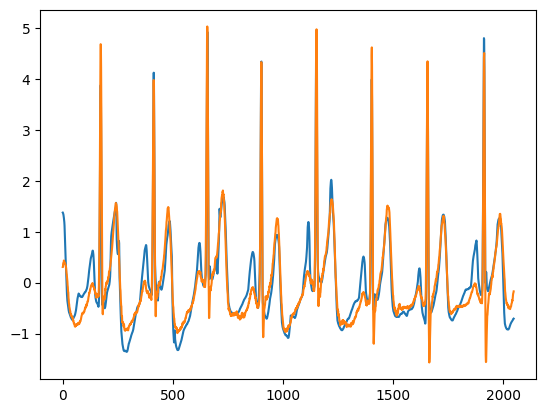

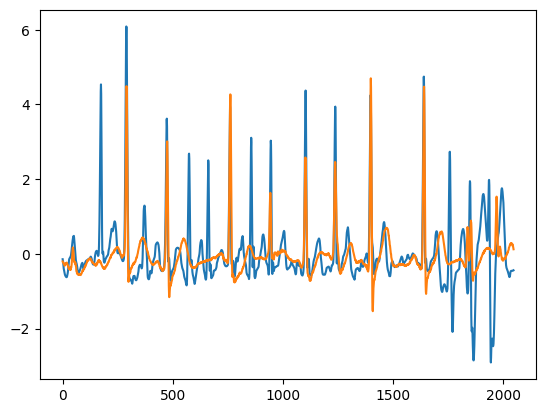

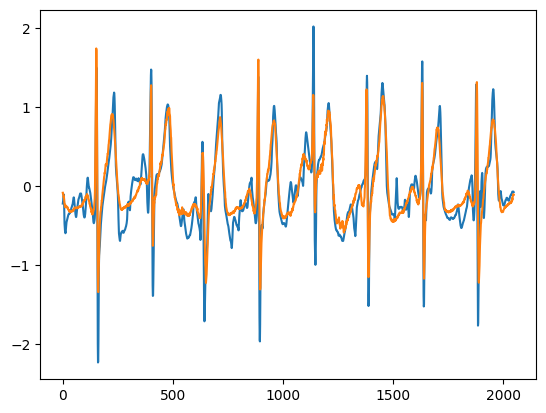

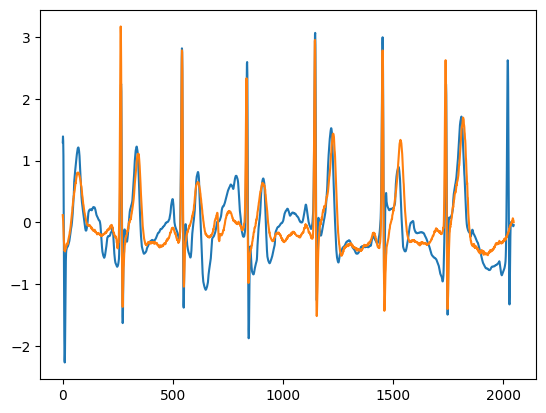

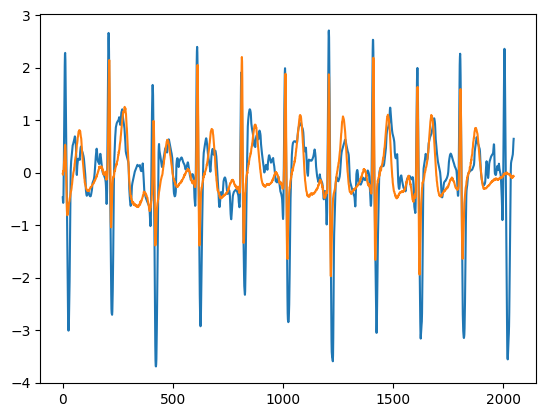

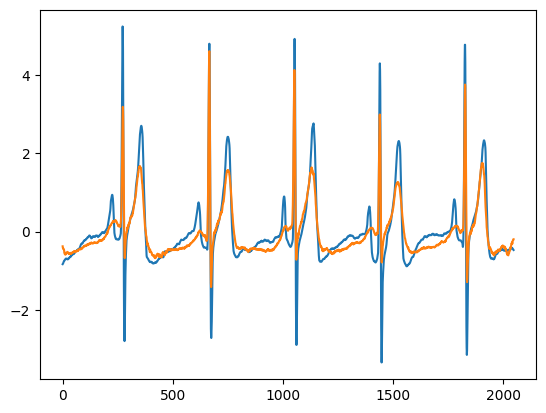

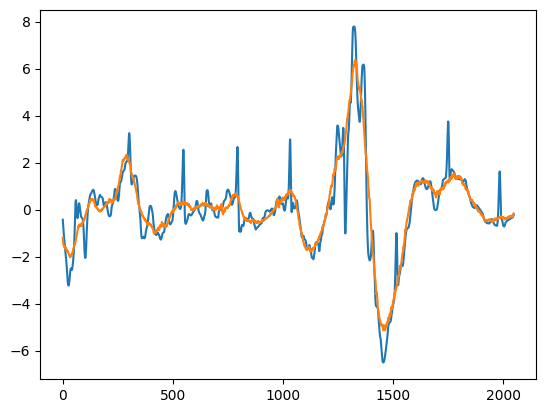

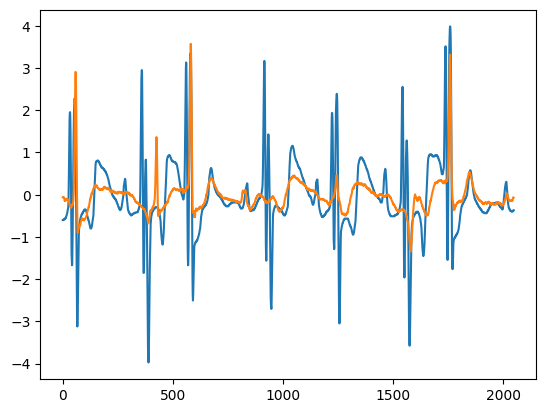

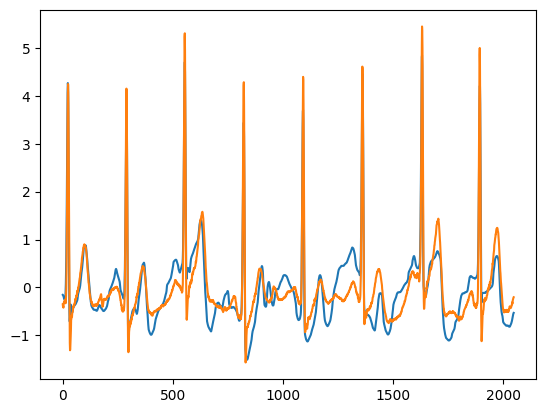

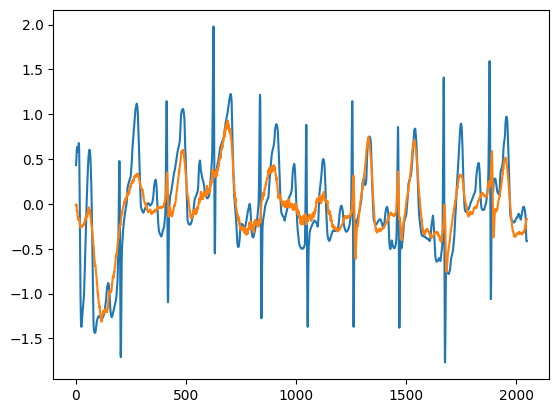

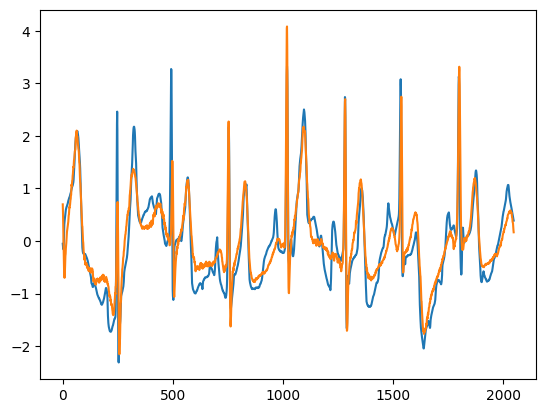

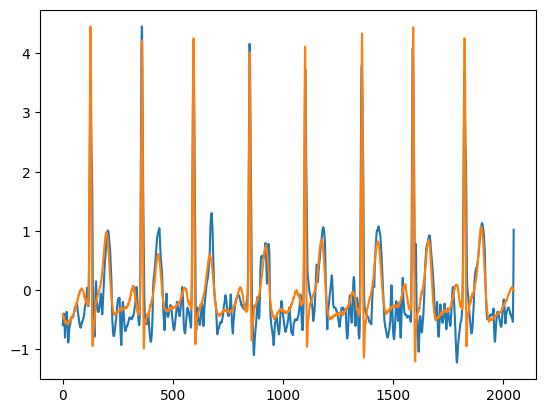

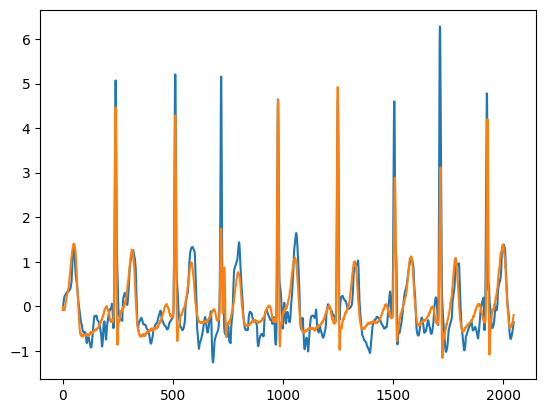

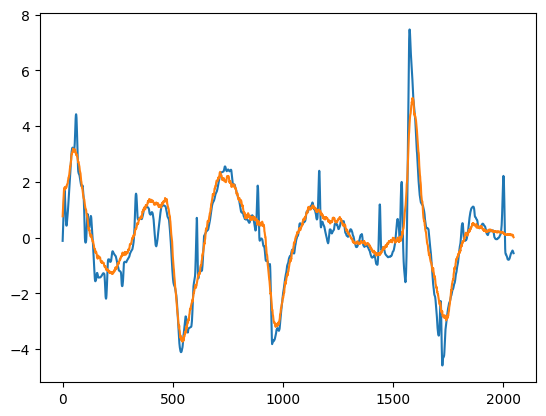

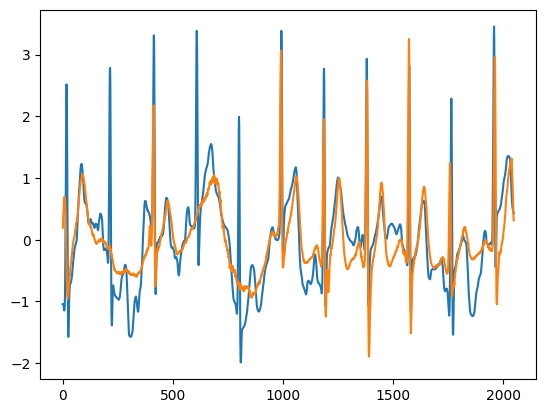

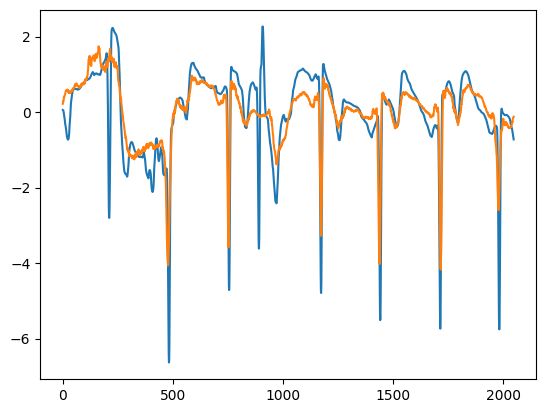

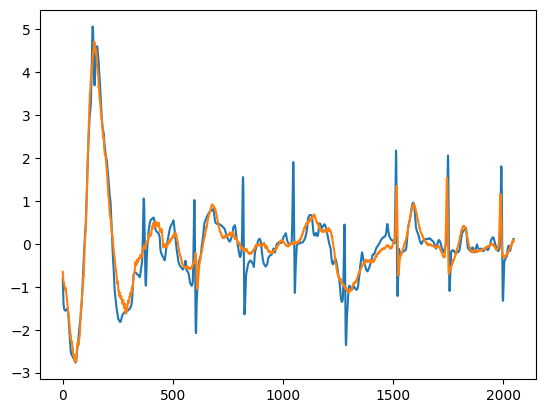

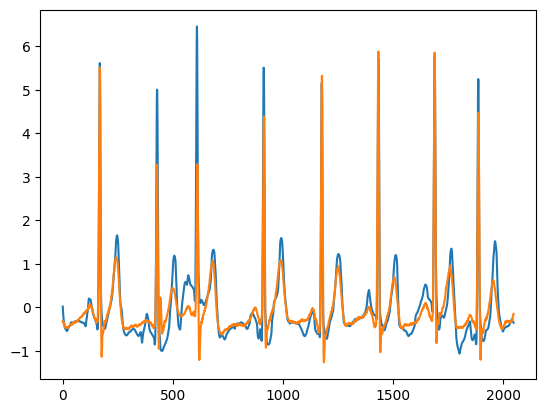

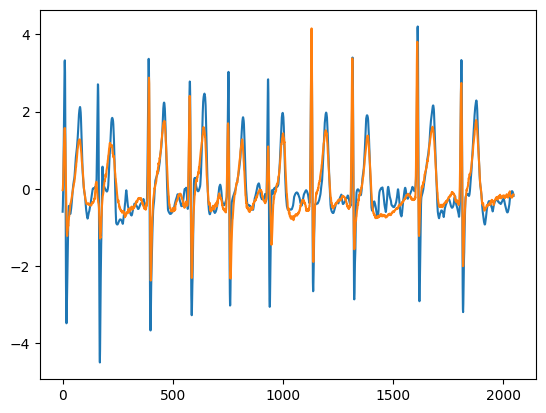

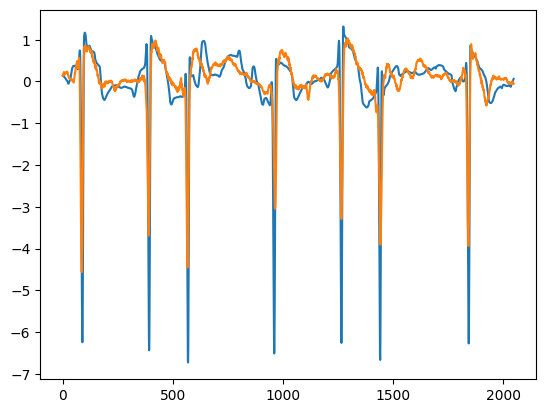

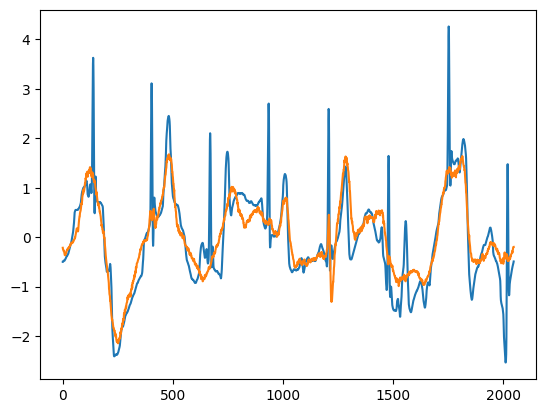

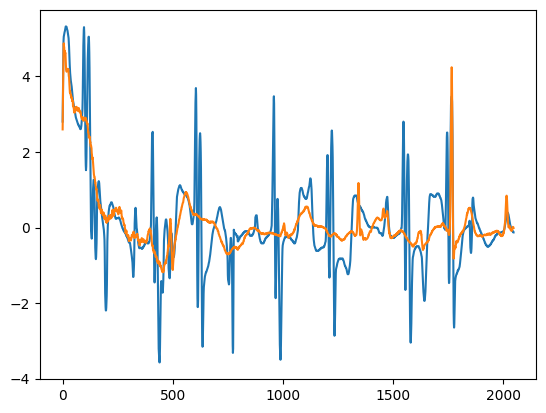

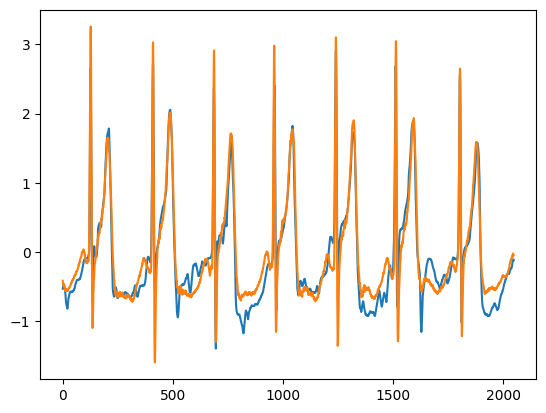

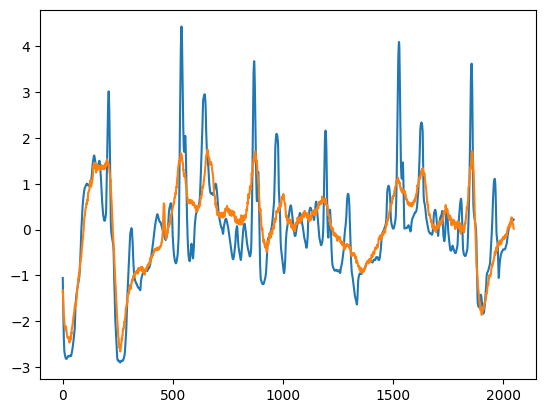

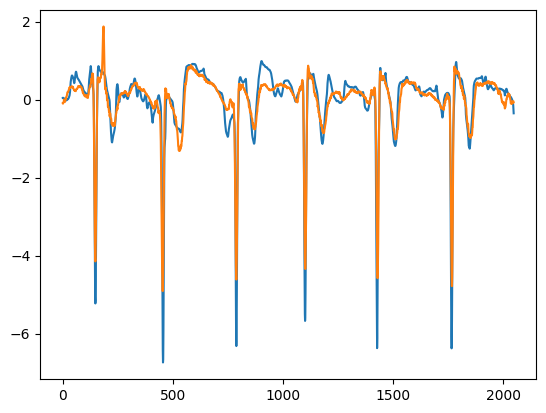

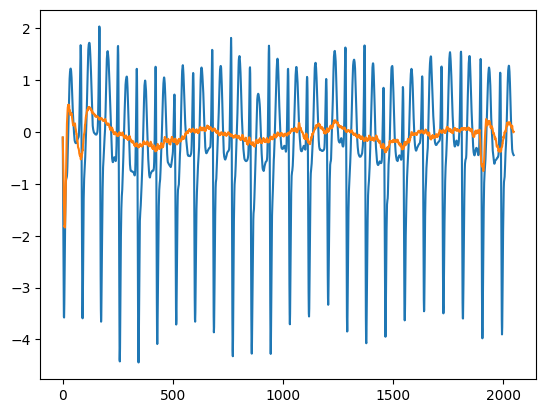

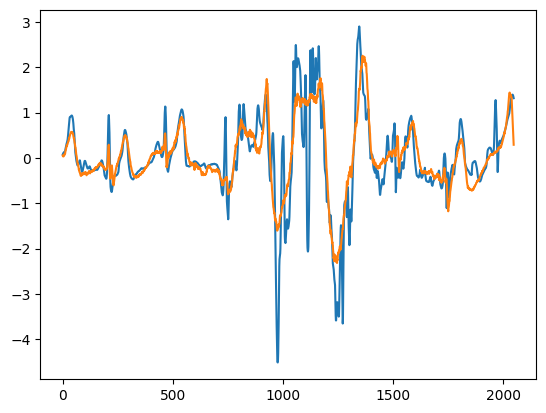

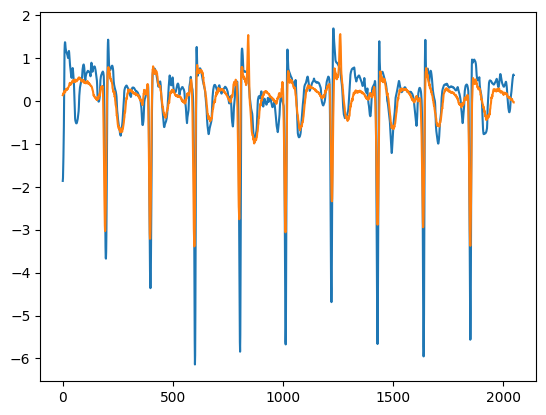

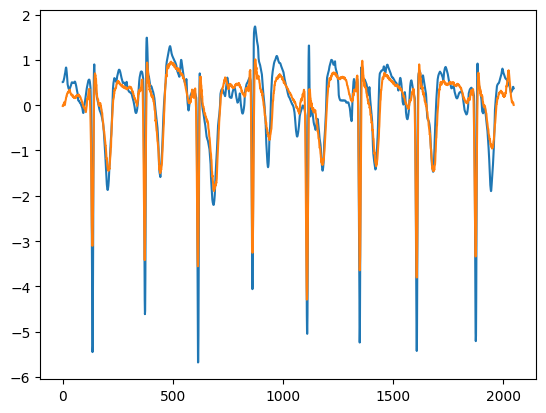

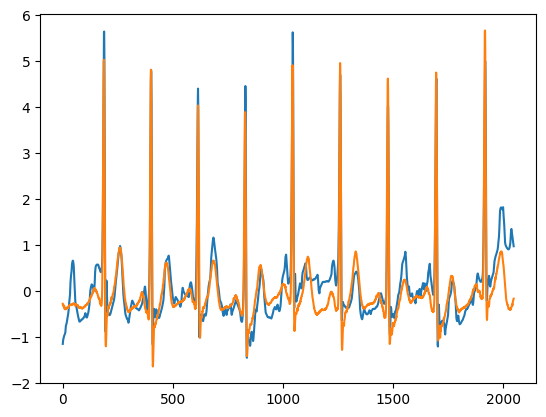

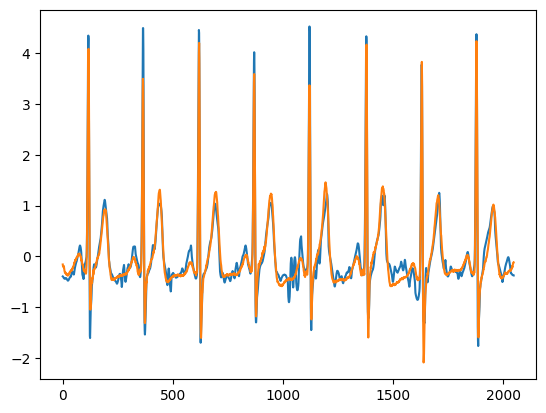

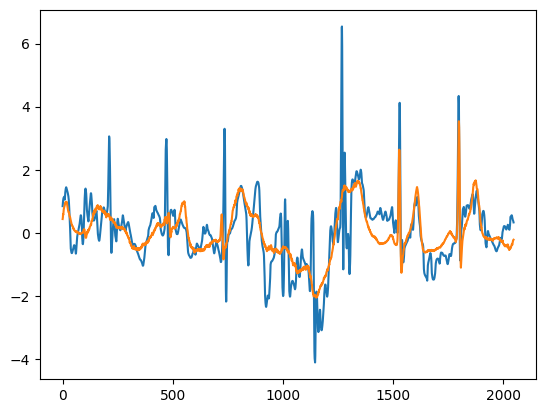

In [37]:
for i in range(32):
    plt.plot(signals_np[i, 0])
    plt.plot(output[i, 0])
    plt.show()

### Reconstruction for noisy samples

In [39]:
# Try on some noisy samples

noisy_dataset = Dataset(split_to_segments(dataset[dataset["class_index"] == 1], 2048, 9000, 0))
noisy_dataloader = DataLoader(noisy_dataset, batch_size=32, shuffle=True, pin_memory=True)

with torch.no_grad():
    model.eval()
    for i, (signals, _) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        output= model(signals).detach().cpu().numpy()
        signals_np = signals.detach().cpu().numpy()

        break

        loss = loss_func(output, signals)
        test_loss += float(loss)

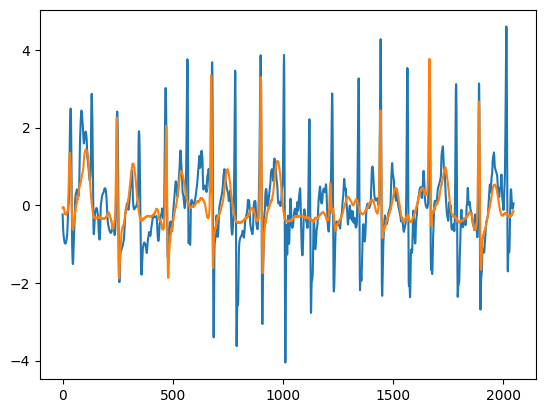

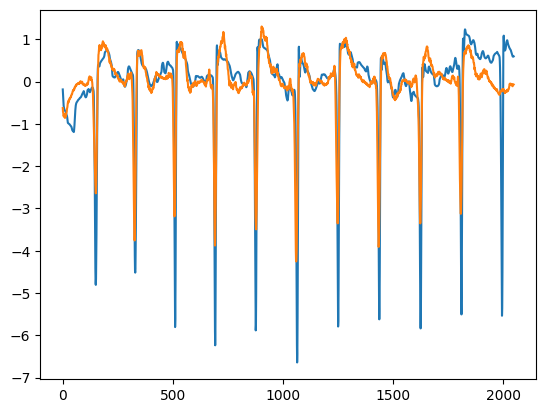

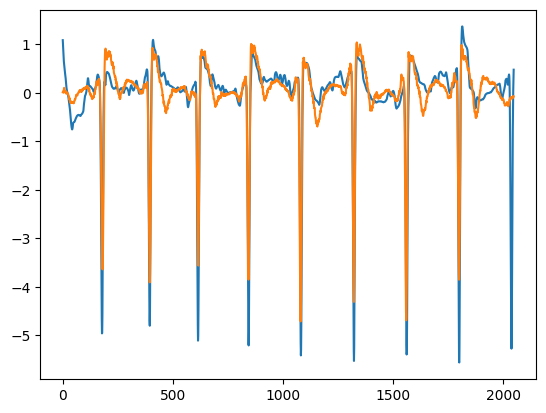

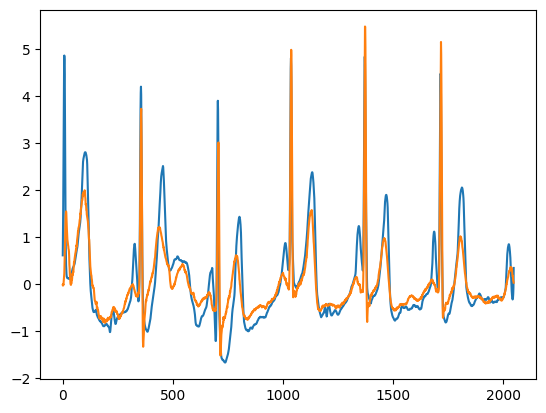

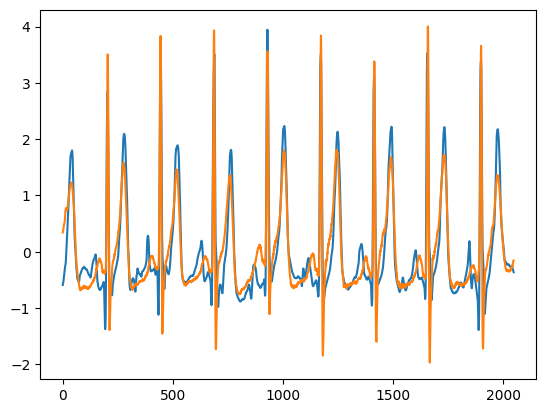

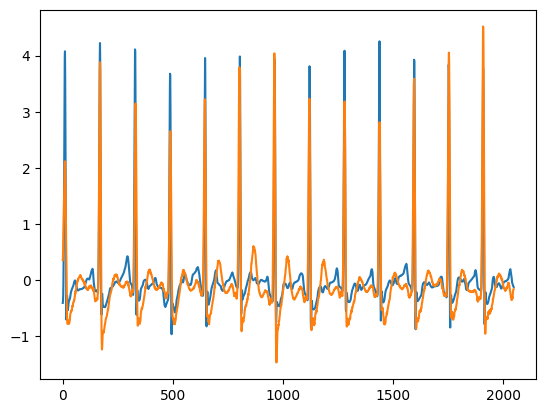

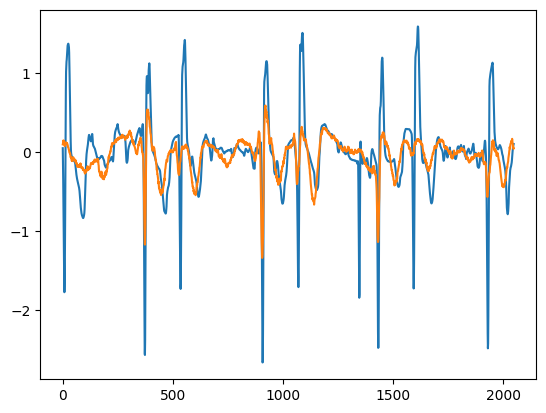

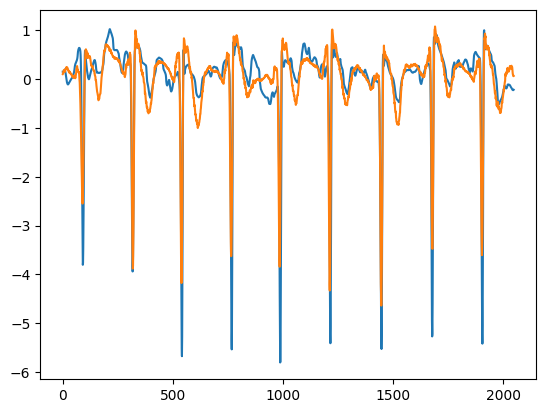

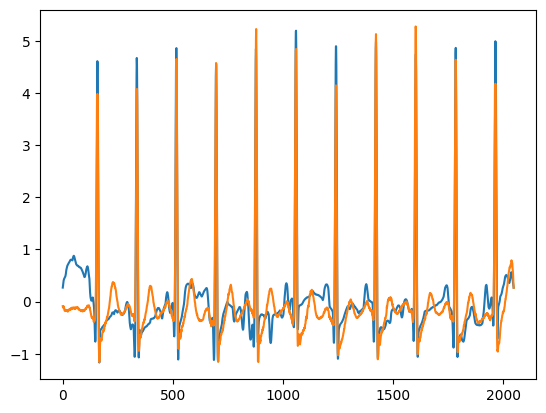

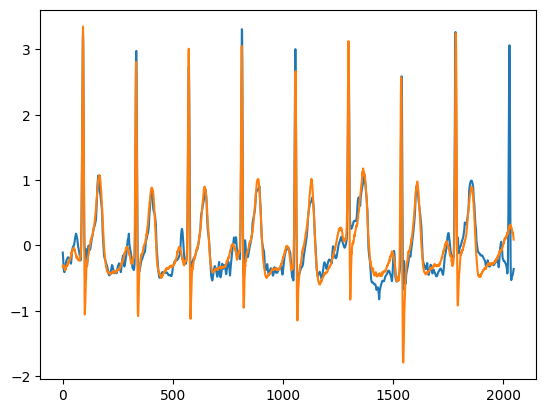

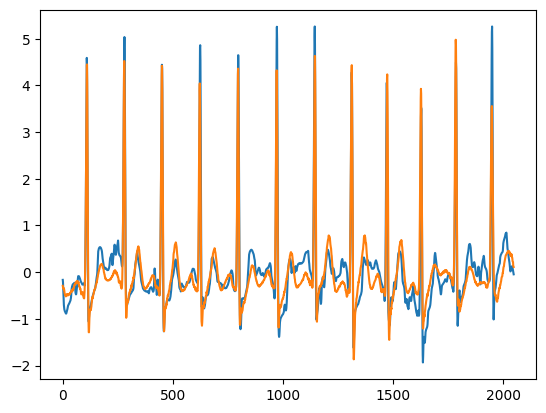

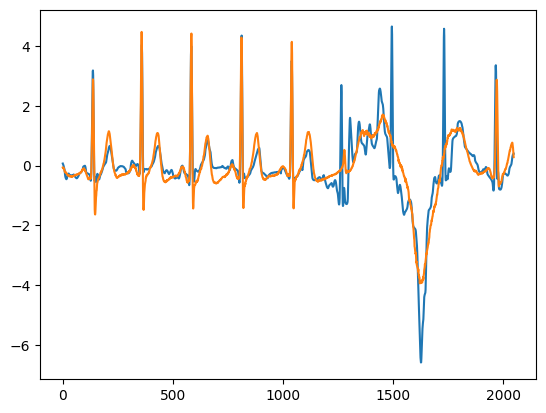

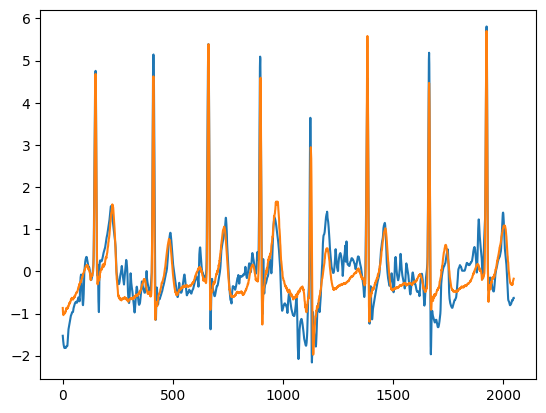

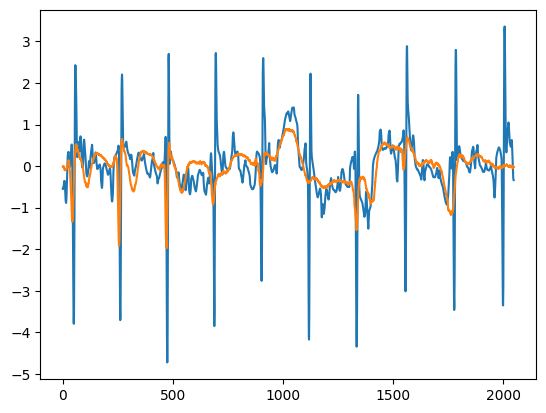

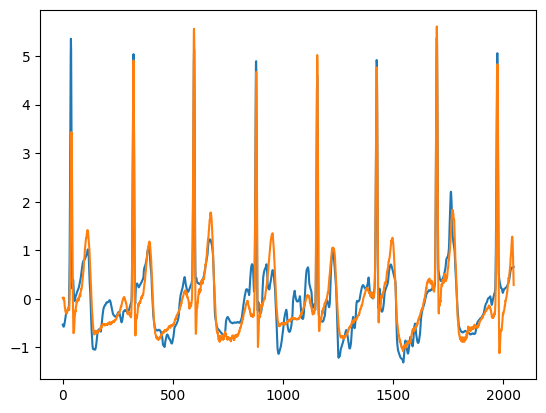

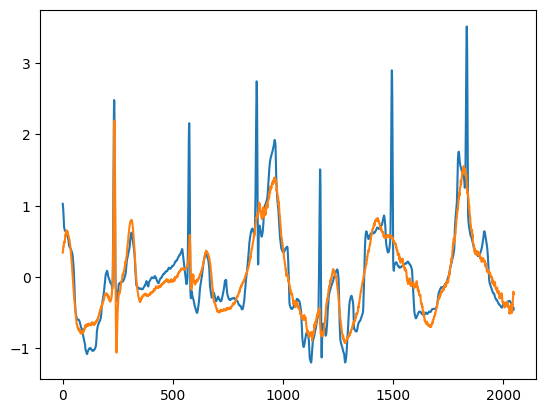

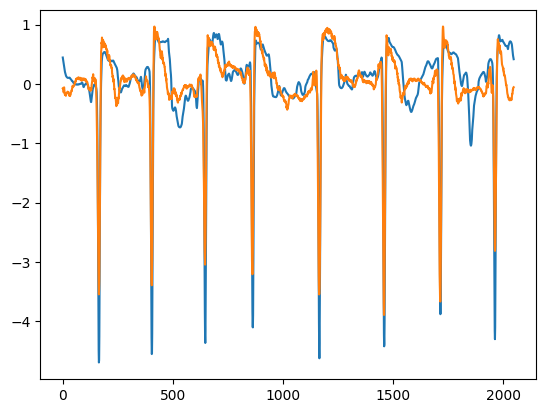

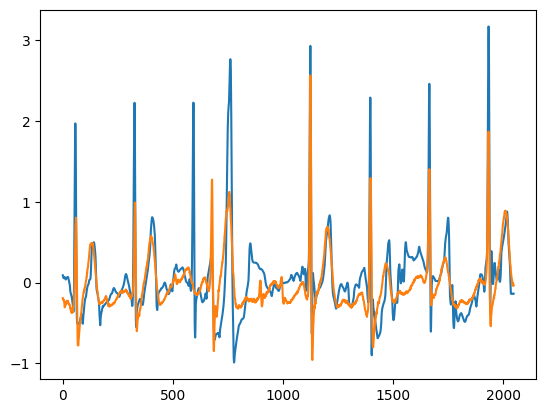

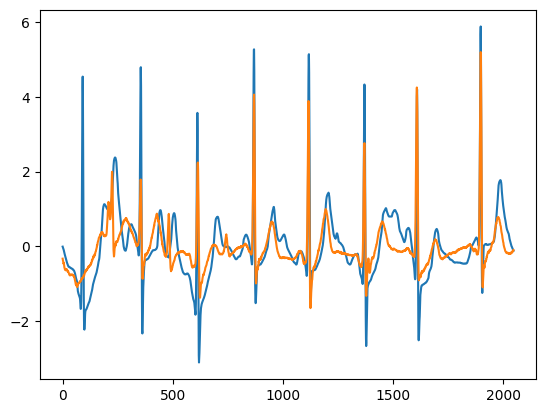

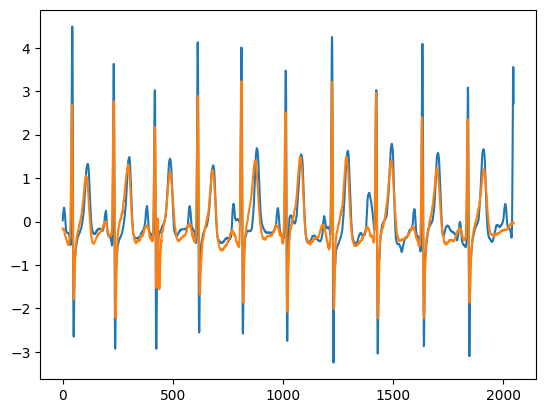

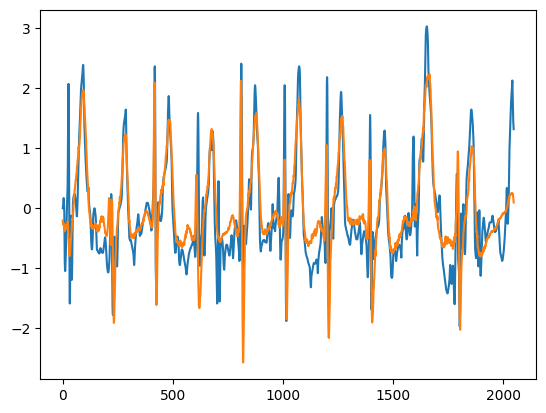

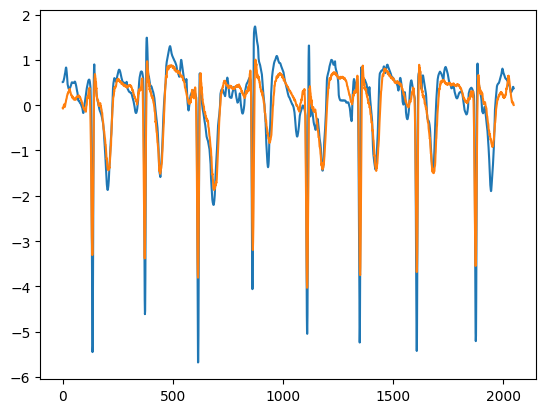

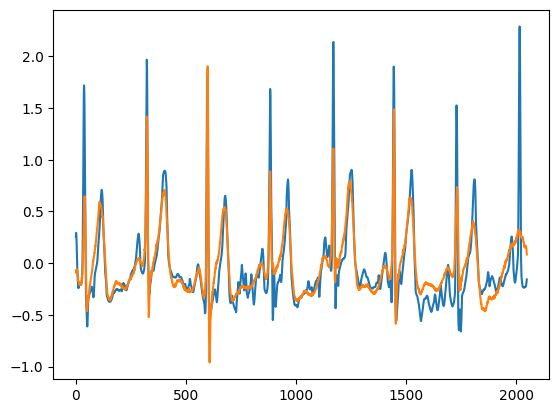

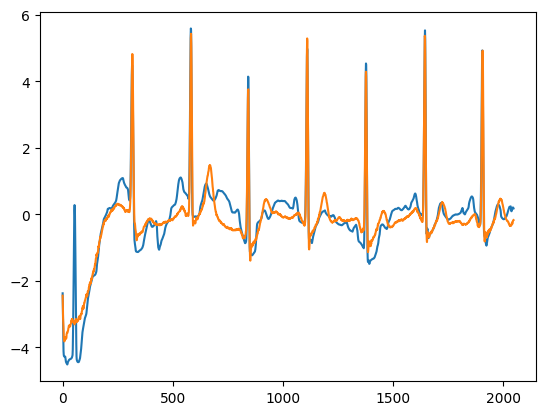

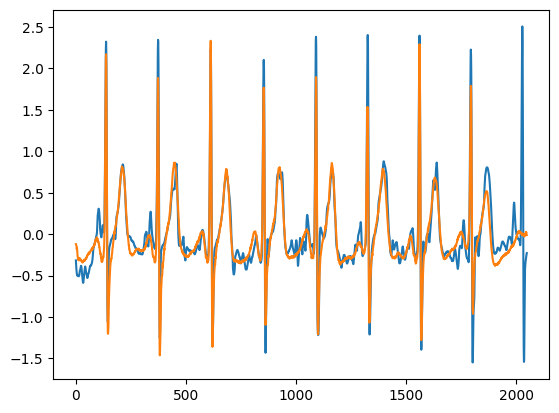

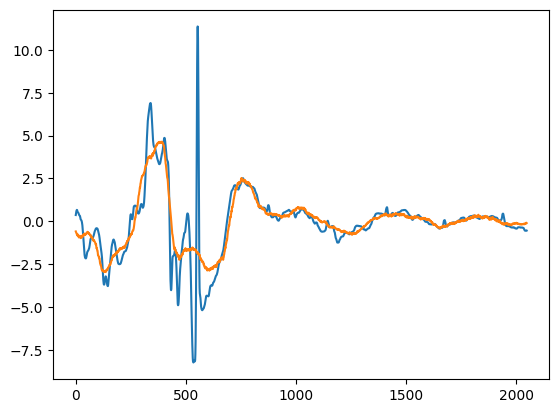

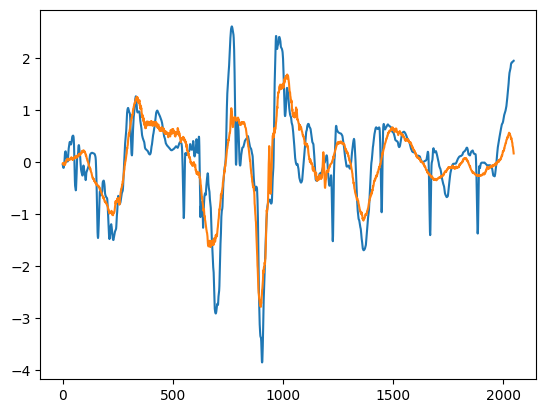

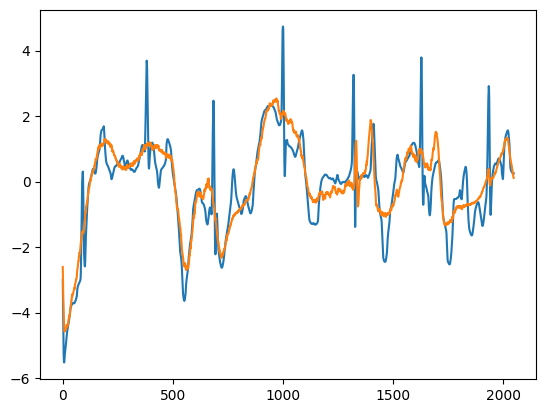

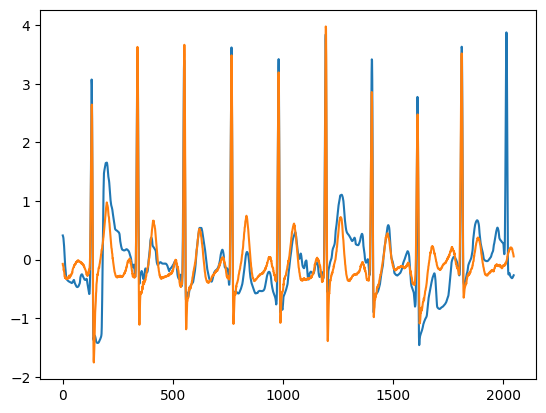

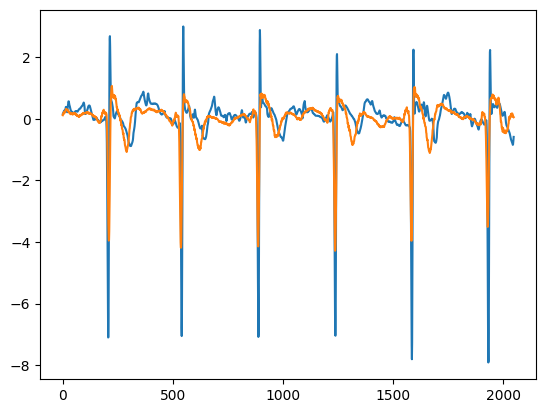

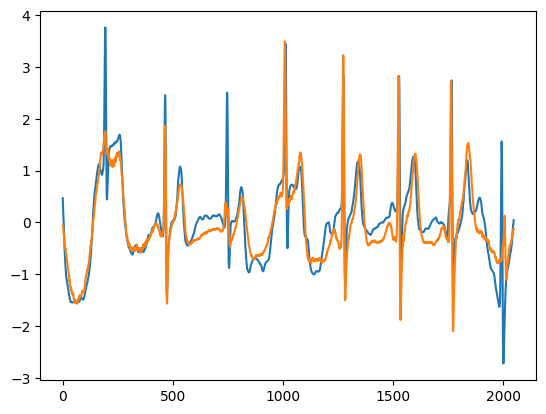

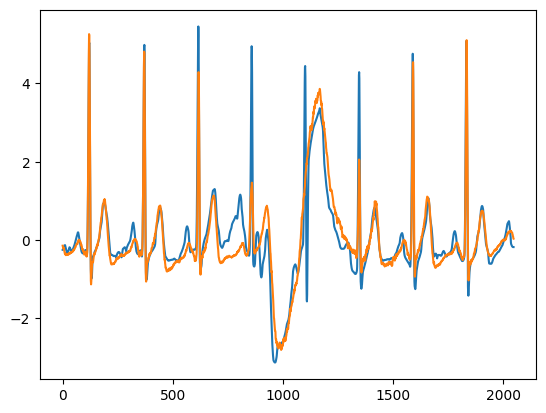

In [40]:
for i in range(32):
    plt.plot(signals_np[i, 0])
    plt.plot(output[i, 0])
    plt.show()

### Latent space exploration

In [87]:
# Try some latent space exploration

with torch.no_grad():
    model.eval()
    for i, (signals, _) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        latent_position = model.encode(signals)
        latent_position = latent_position.detach().cpu().numpy()
        signals_np = signals.detach().cpu().numpy()

        print(latent_position.shape)

        break

index = 0
latent_positions = np.zeros((10, *latent_position.shape), dtype=np.float32)
for i in range(10):
    latent_positions[i, :, :] += latent_position
    latent_positions[i, :, index] = i * 4 - 2

signals = []

with torch.no_grad():
    model.eval()
    for l in latent_positions:
        latent = torch.from_numpy(l[:, :60]).to(device)
        signal = model.decode(latent)
        signals.append(signal.detach().cpu().numpy())

(32, 120)


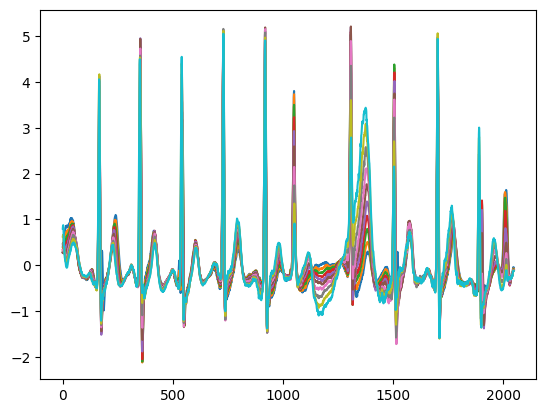

In [88]:
signals = np.array(signals)

for i in range(10):
    plt.plot(signals[:, 0, 0, :].T)
    plt.show()
    break

### Find the reconstruction error for noisy and clean samples

In [34]:
noisy_dataset = Dataset(split_to_segments(test_dataset, 2048, 9000, 0))
noisy_dataloader = DataLoader(noisy_dataset, batch_size=1, shuffle=True, pin_memory=True)

loss_func = torch.nn.MSELoss()

test_reconstruct_err = {"class_index" : [], "r_err": []}

with torch.no_grad():
    model.eval()
    for i, (signals, ci) in enumerate(noisy_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        output = model(signals)
        signals_np = signals

        loss = loss_func(output, signals).detach().cpu().numpy()
        test_reconstruct_err["class_index"].append(ci[0])
        test_reconstruct_err["r_err"].append(loss)


  class_index       r_err
0   tensor(0)   0.3463496
1   tensor(0)  0.10825518
2   tensor(0)  0.07690311
3   tensor(0)     0.28549
4   tensor(0)  0.24019605


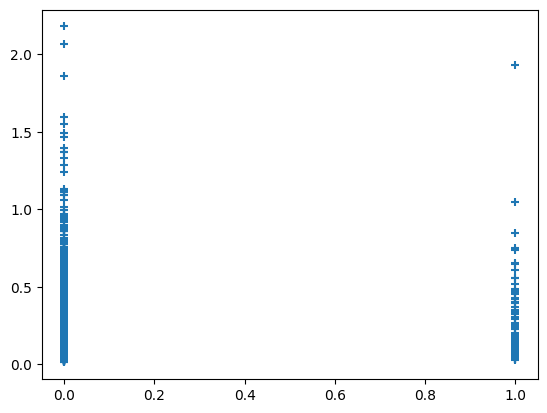

In [35]:
test_reconstruct_err = pd.DataFrame(data=test_reconstruct_err)
print(test_reconstruct_err.head())

plt.scatter(test_reconstruct_err["class_index"], test_reconstruct_err["r_err"], marker='+')
plt.show()

# What, it constructs the noisy samples better?
